# Task 4.2: PCA Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from helper import *
import warnings
import itertools
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Load data

In [11]:
# Training data
X_train_raw, y_train = load_dataset("../data/training1_no_incidents.csv")

# Optimization data
X_optim_raw, y_optim = load_dataset("../data/training2_with_incidents.csv")

# Test data
X_test_raw, _        = load_dataset("../data/test.csv", has_labels=False)
y_test               = get_test_labels(X_test_raw.index)

# Select sensors to consider
sensors = X_train_raw.columns

# Fit scaler on training data
scaler  = preprocessing.StandardScaler()
scaler.fit(X_train_raw[sensors])

# Scale datasets
X_train = scaler.transform(X_train_raw[sensors])
X_optim = scaler.transform(X_optim_raw[sensors])
X_test  = scaler.transform(X_test_raw[sensors])

### Remove outliers from training data
See `4.1 - PCA Analysis` for the threshold justification.

In [12]:
threshold = .01

In [13]:
# Find outliers
_, _, residuals, _ = pca_model(X_train, X_train_raw.index, n_components=len(sensors))
outliers = residuals[residuals > threshold]

In [14]:
# Remove outliers
X_train_raw.drop(outliers.index, inplace=True)
y_train.drop(outliers.index, inplace=True)

# Rescale to unit variance (TODO: check if this is legal)
X_train = preprocessing.StandardScaler().fit_transform(X_train_raw[sensors])

### Optimze PCA model (train on training 1, optimize parameters on training 2)  

In [15]:
# Define search grid
n_pca = range(1,40)
thresholds = [.0005, .001, .002, 0.003, 0.005, .01, .02]

grid = list(itertools.product(n_pca, thresholds))
grid_search_results = {}
models = {}

In [17]:
%%time

for n_components, thresh in grid:
    
    # Fit model to training data
    model, _, _,_ = pca_model(X_train, X_train_raw.index, n_components=n_components)
    
    # Transform optimization data
    _, residuals = pca_pretrained(model, X_optim, X_optim_raw.index)
    
    # Find outliers
    outliers = residuals[residuals > thresh]
    predictions = y_optim.copy()
    predictions[outliers.index] = 1
    
    # Score model and save
    grid_search_results[(n_components, thresh)] = score(y_optim, predictions)
    models[(n_components, thresh)] = model

Wall time: 18.7 s


In [25]:
best = False

print('='*54)
print(' {:7s} {:7s}  |  {:7} {:7} {:7}'.format('n-PCA', 'Thres.', 'Prec.', 'Recall', 'F1'))
print('='*54)

# Sort grid search results on F1-score and display top 25 options
for conf in sorted(grid_search_results, key=lambda x: grid_search_results[x][0], reverse=True)[:10]:
    if not best: best = conf
    print(' {:<7d} {:<7.4f}  |  {:<7.4f} {:<7.4f} {:<7.4f}'.format(*conf, *grid_search_results[conf]))


 n-PCA   Thres.   |  Prec.   Recall  F1     
 4       0.0200   |  0.8588  1.0000  0.9241 
 5       0.0200   |  0.8588  1.0000  0.9241 
 6       0.0200   |  0.8588  1.0000  0.9241 
 7       0.0200   |  0.8588  1.0000  0.9241 
 8       0.0200   |  0.8588  1.0000  0.9241 
 9       0.0200   |  0.8588  1.0000  0.9241 
 10      0.0200   |  0.8588  1.0000  0.9241 
 11      0.0200   |  0.8588  1.0000  0.9241 
 12      0.0200   |  0.8588  1.0000  0.9241 
 13      0.0200   |  0.8588  1.0000  0.9241 


### Evaluate PCA model on test

In [27]:
# Get best model
_, test_threshold = best
test_model = models[best]

# Reconstruct unseen data with pretrained model
_, test_residuals = pca_pretrained(test_model, X_test, X_test_raw.index)

# Find outliers
test_outliers = test_residuals[test_residuals > test_threshold]
test_predictions = y_test.copy()
test_predictions[test_outliers.index] = 1

# Get scores
scores = score(y_test, test_predictions)

# Print results
print('{:7} {:7} {:7}'.format('Prec.', 'Recall', 'F1'))
print('{:<7.4f} {:<7.4f} {:<7.4f}'.format(*scores))

Prec.   Recall  F1     
0.9951  1.0000  0.9975 


In [21]:
df = pd.DataFrame()
df['labels'] = y_test
df['pred'] = test_predictions

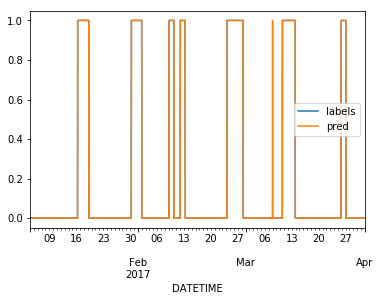

In [22]:
df.plot.line()